# Simple stable diffusion notebook

## Install requirements

In [1]:
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%pip install -r requirements-torch-windows.txt --upgrade
%pip install -r requirements.txt --upgrade

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Init stable diffusion

In [3]:
from diffusers import StableDiffusionXLPipeline
import torch

def init_pipeline(model_id):
    pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
    _ = pipe.to("cuda")
    # pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True) # Not supported on windows yet
    return pipe

pipeline = init_pipeline("stabilityai/stable-diffusion-xl-base-1.0")

C:\Users\key\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


In [4]:
def generate(prompt1, prompt2=None, height=1024, width=1024, negative_prompt1=None, negative_prompt2=None, seed=42):
    generator = torch.Generator("cuda").manual_seed(seed)
    image = pipeline(prompt1, prompt2, height=height,width=width,negative_prompt=negative_prompt1,negative_prompt_2=negative_prompt2, generator=generator).images[0]
    fname = f"images/{prompt1.replace(' ','-')}.png"
    image.save(fname)
    display(image)
    return image

# Run

100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


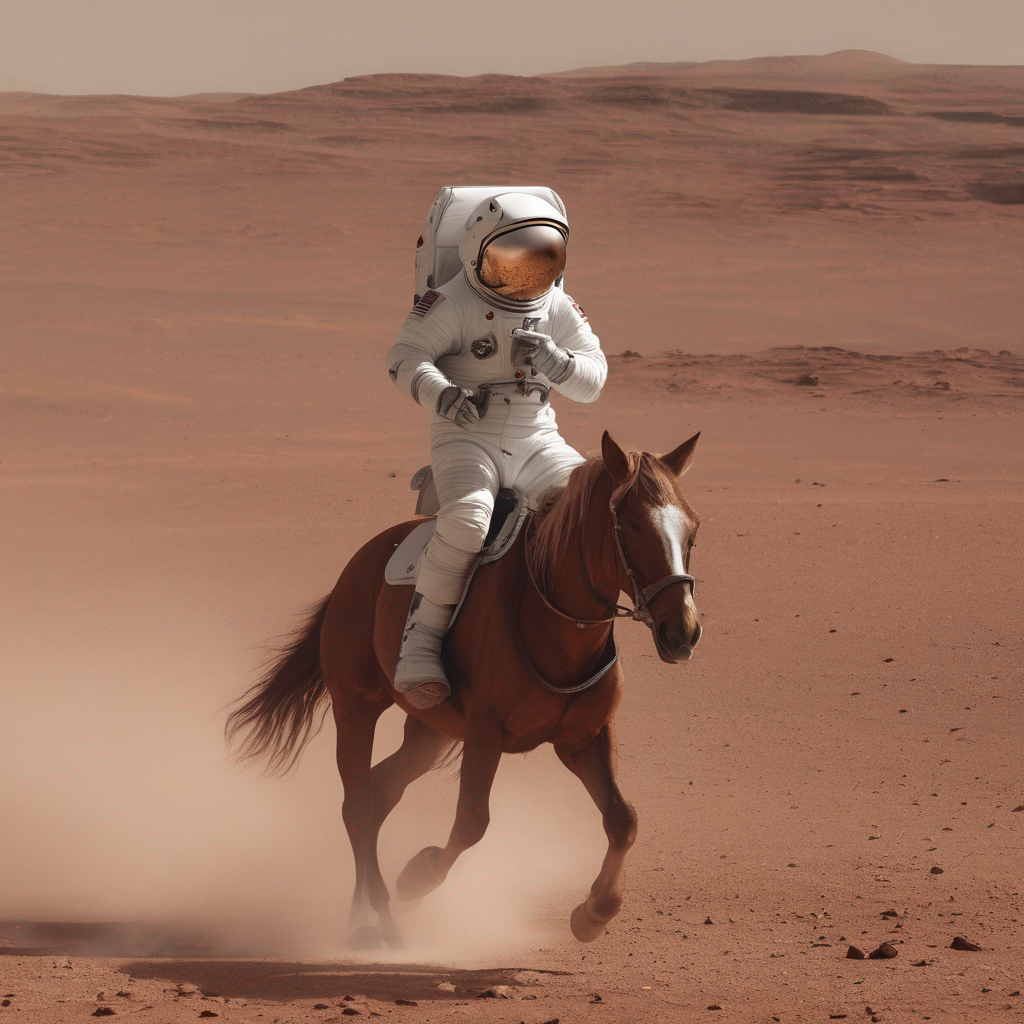

In [5]:
img = generate("a photo of an astronaut riding a horse on mars")